# Prepare data

We load all song titles as paths to each song, shuffle them and construct 3 seperate .txt files with paths for each split (train, validation, test). This is important because during training we always slice 5 second long snippets from random audio files from the train-split and tehrefore need to have seperate .txt files for the splits.

In [1]:
import sys
import os
#import h5py
import pandas as pd
import random
from random import shuffle
import torch
import torch.nn.functional as F
#import torchvision
import torchaudio
import torchaudio.transforms as tat
from torch.utils.data import TensorDataset, random_split, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from IPython.display import Audio
from torchaudio_augmentations import (
    RandomApply,#
    Compose,
    RandomResizedCrop,
    PolarityInversion,
    Noise,
    Gain,
    HighLowPass,
    Delay,
    PitchShift,
    Reverb,
    Reverse,
    LowPassFilter,
    HighPassFilter,
)

sys.path.append('../')

from models.gtzan_dataset import AudioDataset, get_loader

### Define paths

In [2]:
data_path = '../../Data/original_txt_cleaned/'
data_splits = ['train', 'valid', 'test']
path_to_genres = '../../Data/genres_original/'

### Define functions for loading and splitting song titles in seperate splits

In [3]:
genres = {"pop" : 0, "metal" : 1, "disco" : 2, "blues" : 3, "reggae" : 4, "classical" : 5, "rock" : 6, "hiphop" : 7, "country" : 8, "jazz" : 9}
random.seed(42)

def load_and_split(data_path, genres, split=[0.7, 0.1, 0.2]):

    train_split = []
    valid_split = []
    test_split = []
    genre_count = {}
    for genre in genres.keys():
        all_songs = []
        # get song names (and construct this form: 'jazz/jazz.00023.wav')
        for filename in os.listdir(os.path.join(data_path, genre)):
            # ignore files like .DS_Store
            if not filename.startswith("."):
                genre = filename[0:filename.find('.')]
                name = genre + "/" + filename
                all_songs.append(name)
        
        # safe number of datapoint per genre to print
        genre_count[genre] = len(all_songs)
        # split each genre so that each genre is of same weight in each split
        tr, vl, ts = shuffle_and_split(all_songs, split=split)
        train_split.extend(tr), valid_split.extend(vl), test_split.extend(ts)
    
    np.random.shuffle(train_split), np.random.shuffle(valid_split), np.random.shuffle(test_split)

    # print datapoints per genre
    print('All datapoints per genre:')
    print('-'*20)
    for genre in genre_count.keys():
        print(f'{genre_count[genre]} audio files in genre: {genre}')
    print('-'*20)

    return train_split, valid_split, test_split

def get_songs_cleaned(data_path, data_splits, split=[0.7, 0.1, 0.2]):
    
    genre_list = {"pop" : [], "metal" : [], "disco" : [], "blues" : [], "reggae" : [], "classical" : [], "rock" : [], "hiphop" : [], "country" : [], "jazz" : []}

    # get all song names and append to each genre songlist
    for split in data_splits:
        # get song names (e.g., 'jazz/jazz.00023.wav')
        list_filename = os.path.join(data_path, '%s_filtered.txt' % split)
        with open(list_filename) as f:
            lines = f.readlines()
        songs = [line.strip() for line in lines]
        for song_name in songs:
            genre = song_name[0:song_name.find('/')]
            genre_list[genre].append(song_name)

    train_split = []
    valid_split = []
    test_split = []
    # shuffle and split each genre
    for genre in genre_list.keys():
        tr, vl, ts = shuffle_and_split(genre_list[genre], split=split)
        train_split.extend(tr), valid_split.extend(vl), test_split.extend(ts)

    np.random.shuffle(train_split), np.random.shuffle(valid_split), np.random.shuffle(test_split)
    return train_split, valid_split, test_split

def shuffle_and_split(songs, split=[0.7, 0.1, 0.2], shuffle=True):
    songnames = songs
    # shuffle if shuffle
    if shuffle:
        np.random.shuffle(songnames)
    # get length for convenience
    length = len(songs)

    train_split = songs[:int(split[0]*length)]
    valid_split = songs[int(split[0]*length):int((split[0]+split[1])*length)]
    if len(split) > 2:
        test_split = songs[int((split[0]+split[1])*length):]
    else: 
        test_split = []
    return [train_split, valid_split, test_split]

def count_songs_per_genre(songnames):
    
    genre_count = {"pop" : 0, "metal" : 0, "disco" : 0, "blues" : 0, "reggae" : 0, "classical" : 0, "rock" : 0, "hiphop" : 0, "country" : 0, "jazz" : 0}
    for name in songnames:
        genre = name[0:name.find('/')]
        genre_count[genre] += 1
    return genre_count

def save_data(path, data, suffix, splits = ["train_split", "validation_split", "test_split"]):
    for i, split in enumerate(splits):
        with open(os.path.join(path, split + suffix + ".txt"), "w") as output:
            for item in data[i]:
                # write each item on a new line
                output.write("%s\n" % item)

### Perform the splitting

In [20]:
'''
ALL SONGS
'''
train_split, valid_split, test_split = load_and_split(path_to_genres, genres)

genre_train = count_songs_per_genre(train_split)
genre_valid = count_songs_per_genre(valid_split)
genre_test = count_songs_per_genre(test_split)
print('Datapoints per genre in each split:')
print(genre_train)
print(genre_valid)
print(genre_test)

# save splits as txt files
#save_data('../../Data/', [train_split, valid_split, test_split], suffix='_all')

All datapoints per genre:
--------------------
100 audio files in genre: pop
100 audio files in genre: metal
100 audio files in genre: disco
100 audio files in genre: blues
100 audio files in genre: reggae
100 audio files in genre: classical
100 audio files in genre: rock
100 audio files in genre: hiphop
100 audio files in genre: country
99 audio files in genre: jazz
--------------------
Datapoints per genre in each split:
{'pop': 70, 'metal': 70, 'disco': 70, 'blues': 70, 'reggae': 70, 'classical': 70, 'rock': 70, 'hiphop': 70, 'country': 70, 'jazz': 69}
{'pop': 10, 'metal': 10, 'disco': 10, 'blues': 10, 'reggae': 10, 'classical': 10, 'rock': 10, 'hiphop': 10, 'country': 10, 'jazz': 10}
{'pop': 20, 'metal': 20, 'disco': 20, 'blues': 20, 'reggae': 20, 'classical': 20, 'rock': 20, 'hiphop': 20, 'country': 20, 'jazz': 20}


## k-Fold Cross Validation

In [7]:
import glob

def get_songs(path, classes):
    # get singtitles and split into each genre
    
    for f in glob.glob(os.path.join(path, 'fold*.txt')):
        with open(f, 'r') as f:
            for line in f.readlines():
                classes[str.split(line, '/')[0]].append(line[:-1])
    return classes

def make_folds(path, folds, genre_list):
    split_size = 1/folds
    for i in range(folds):
        disjoint_fold = []
        for genre in genre_list.keys():
            length = len(genre_list[genre])
            # split each genre so that each genre is of same weight in each split
            disjoint_fold.extend(genre_list[genre][int(i*split_size*length):int((i+1)*split_size*length)])
        # shuffle ordered lists
        np.random.shuffle(disjoint_fold)
        #disjoint_folds[i] = disjoint_fold
        save_data(path, data=[disjoint_fold], suffix='%i' % (i+1), splits=['fold_'])
    
    """# combine folds into 5 disjoint splits
    for i in range(folds):
        train_split = []
        for j, fold in enumerate(disjoint_folds):
            if j != i:
                train_split.extend(fold)
        valid_split = disjoint_folds[i]
        save_data(path, data=[train_split, valid_split], suffix='%i' % (i+1), splits=['train_split', 'valid_split'])"""

### Folds for GTZAN

In [9]:
# load all songtitles
path = '/Users/samuelharck/Desktop/masterthesis/other_datasets/GTZAN16k'
genre_list = {"pop" : [], "metal" : [], "disco" : [], "blues" : [], "reggae" : [], "classical" : [], "rock" : [], "hiphop" : [], "country" : [], "jazz" : []}
genre_list = get_songs(path, genre_list)
genre_list
make_folds('/Users/samuelharck/Desktop/folds/', 10, genre_list)

### Found a 'cleaned' version of the GTZAN dataset but without much clarification

In [19]:
'''
CLEANED VERSION

'''
train_split, valid_split, test_split = get_songs_cleaned(data_path, data_splits)

genre_train = count_songs_per_genre(train_split)
genre_valid = count_songs_per_genre(valid_split)
genre_test = count_songs_per_genre(test_split)
print('Datapoints per genre in each split (cleaned version):')
print(genre_train)
print(genre_valid)
print(genre_test)

#save_data('../../Data/', [train_split, valid_split, test_split], suffix='_cleaned')

Datapoints per genre in each split (cleaned version):
{'pop': 58, 'metal': 63, 'disco': 65, 'blues': 70, 'reggae': 60, 'classical': 69, 'rock': 70, 'hiphop': 64, 'country': 68, 'jazz': 60}
{'pop': 9, 'metal': 9, 'disco': 9, 'blues': 10, 'reggae': 8, 'classical': 10, 'rock': 10, 'hiphop': 9, 'country': 10, 'jazz': 8}
{'pop': 17, 'metal': 19, 'disco': 19, 'blues': 20, 'reggae': 18, 'classical': 20, 'rock': 20, 'hiphop': 19, 'country': 20, 'jazz': 18}


## Get dataset statistics for normalization in dataset and dataloadaer

In [3]:
from utils import rms_normalizer, peak_normalizer, get_toy_samplelist

def get_filelist(path, single_fold=None, is_toy=False):
    """
    Function to get list of all files GTZAN dataset or toy dataset.
    """
    
    filelist = []
    if not is_toy:
        # get all songs GTZAN data
        for fold in range(1,6):
            list_filename = os.path.join(path, 'fold_' + str(fold) + '.txt')
            with open(list_filename) as f:
                lines = f.readlines()
            if fold == single_fold:
                # if songlist of single fold is wanted return it 
                return [line.strip() for line in lines]
            else:
                # extend songlist
                filelist.extend([line.strip() for line in lines])
    else:
        # get all snogs from toy data
        for split in ['train', 'valid', 'test']:
            list_filename = os.path.join(path, split + '_split.txt')
            with open(list_filename) as f:
                lines = f.readlines()
            filelist.extend([line.strip() for line in lines])

    return filelist


def calculate_dataset_statistics(path, mel_converter, to_db, slice_length=6, num_chunks=5, case=None):
        """
        Function to obtain dataset statistics.
        """

        # list all files in dataset
        filelist = get_filelist(path)

        # iterate over all datasamples in each split
        all_spectrograms = []

        for audio_name in filelist:

            # load audio, if not toy, append dir name to audio_name
            if case != 'toy':
                audio_name = os.path.join('genres_original', audio_name)

            wav, sample_rate = torchaudio.load(os.path.join(path, audio_name))
            
            # normalize by dB
            #wav = rms_normalizer(wav)
            wav = peak_normalizer(wav)
            
            if case != 'toy':
                # extract 6 5second long snippets of each audio (each audio is 29s long)
                hop = (wav.size(1) - slice_length*sample_rate) // num_chunks
                wav = torch.stack([wav[:, i * hop : i * hop + slice_length*sample_rate] for i in range(num_chunks)])
            
            # Apply spectrogram transformation
            mel = mel_converter(wav.squeeze(1))
            
            # if is_toy, discard last 3 time bins to get shape 64x64
            if case=='toy':
                mel = mel[..., :-3]
            elif case=='square128':
                mel = mel[..., 1:-1]
            elif case=='128_256':
                mel = mel[..., 1:-2]
                
            mel_db = to_db(mel)
            all_spectrograms.extend(mel_db)

        # Stack all spectrograms to calculate mean and std
        all_spectrograms = torch.stack(all_spectrograms)
        
        # get mean ans std across bacth nad time dimension (keep mel bins)
        mean = all_spectrograms.mean()
        std = all_spectrograms.std()
        data_min = torch.min(all_spectrograms)
        data_max = torch.max(all_spectrograms)
        
        return mean, std, data_min, data_max, all_spectrograms



from utils import get_songlist, load_sample, get_slice


#wav_sample = get_slice(wav_test, slice_length=3, start_point=startpoints[idx])

resampler = torchaudio.transforms.Resample(22050, 16000)
tospec = torchaudio.transforms.Spectrogram(n_fft=800, hop_length=360, power=None)
spec2mel = torchaudio.transforms.MelScale(n_mels=128, n_stft=401)

def calculate_dataset_statistics_new(path, slice_length=3, num_chunks=9, case='128_256', audio_normalization='rms'):
        """
        Function to obtain dataset statistics.
        """

        if case == 'toy':
            songlist = get_toy_samplelist(path, splits='train')
        else:
            # list all files in dataset
            songlist = get_songlist(path, return_dict = False)

        print(len(songlist))

        # iterate over all datasamples in each split
        all_mels = []
        extended_songlist = []

        for path_to_song in songlist:

            wav, _ = torchaudio.load(path_to_song)
            wav = resampler(wav)
            wav = get_slice(wav, slice_length=slice_length, num_chunks=num_chunks, sample_rate=16000)

            wav = wav / torch.max(torch.max(wav, dim=-1, keepdim=True)[0], dim=-2, keepdim=True)[0]
            spec = tospec(wav)
            mel = spec2mel(torch.abs(spec))
            mel = torch.log10(mel+1e-7)
            mel = torch.clamp(mel, -4)

            #mel = 2*((mel-mel.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]) / \
            #         (mel.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0] - mel.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0])) - 1

            all_mels.extend(mel.squeeze())

            for _ in range(num_chunks):
                extended_songlist.append(path_to_song)

        # Stack all spectrograms to calculate mean and std
        all_mels = torch.stack(all_mels)

        print(all_mels.size())
        
        # get mean ans std across bacth nad time dimension (keep mel bins)
        mean = all_mels.mean()
        std = all_mels.std()
        data_min = torch.min(all_mels)
        data_max = torch.max(all_mels)
        
        return mean, std, data_min, data_max, all_mels, extended_songlist

def calculate_dataset_statistics2(path, slice_length=6, num_chunks=5, case='128_256', audio_normalization='rms'):
        """
        Function to obtain dataset statistics.
        """

        if case == 'toy':
            songlist = get_toy_samplelist(path, splits='train')
        else:
            # list all files in dataset
            songlist = get_songlist(path, return_dict = False)

        

        # iterate over all datasamples in each split
        all_mels = []
        

        for path_to_song in songlist:

            mel, _ = load_sample(path_to_song, slice_length=slice_length, num_chunks=num_chunks, case=case, normalize=False, audio_normalization=audio_normalization)
            all_mels.extend(mel)
            

        # Stack all spectrograms to calculate mean and std
        all_mels = torch.stack(all_mels)

        print(all_mels.size())
        
        # get mean ans std across bacth nad time dimension (keep mel bins)
        mean = all_mels.mean()
        std = all_mels.std()
        data_min = torch.min(all_mels)
        data_max = torch.max(all_mels)
        
        return mean, std, data_min, data_max, all_mels

## GTZAN Data

## (128,256)

In [4]:
mean, std, data_min, data_max, all_specs, extended_songlist = calculate_dataset_statistics_new('/Users/samuelharck/Desktop/GTZAN16k', slice_length=6, num_chunks=5, case='128_256', audio_normalization='rms')
print(mean, std, data_min, data_max)

998
torch.Size([4990, 128, 267])
tensor(0.2496) tensor(0.5904) tensor(-4.) tensor(2.3771)


In [171]:
all_specs.shape

torch.Size([4990, 128, 267])

In [198]:
"""path = '/Users/samuelharck/Desktop/masterthesis/data'
out = '/Users/samuelharck/Desktop/GTZAN16k/genres_original'

from constants import CLASS_IDX_MAPPER
from tqdm import tqdm
from utils import HiddenPrints

#for key in CLASS_IDX_MAPPER.keys():
#    os.makedirs(os.path.join(out, key))

songlist = get_songlist(path, return_dict = False)

for path_to_song in tqdm(songlist):

    genre, songname = path_to_song.split('/')[-2:]

    wav, _ = torchaudio.load(path_to_song)
    wav = resampler(wav)

    with HiddenPrints():
        torchaudio.save(os.path.join(out, genre, songname), wav, sample_rate=16000)
"""



100%|██████████| 998/998 [00:15<00:00, 63.45it/s]


In [192]:
path_to_song

'/Users/samuelharck/Desktop/masterthesis/data/genres_original/pop/pop.00033.wav'

## Important, HipHop genre low amplitudes

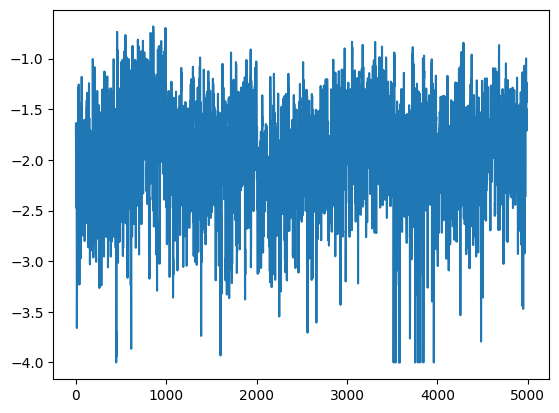

In [172]:
min_vals = torch.min(torch.min(all_specs, dim=-1)[0], dim=-1)[0]
plt.plot(min_vals)

In [147]:
idcs = list(torch.where(min_vals == -4)[0].numpy().flatten())
idcs

[446, 3515, 3537, 3575, 3585, 3755, 3785, 3810, 3811, 3845, 3960]

In [148]:
for idx in idcs:
    print(extended_songlist[idx])

/Users/samuelharck/Desktop/masterthesis/data/genres_original/pop/pop.00053.wav
/Users/samuelharck/Desktop/masterthesis/data/genres_original/hiphop/hiphop.00039.wav
/Users/samuelharck/Desktop/masterthesis/data/genres_original/hiphop/hiphop.00063.wav
/Users/samuelharck/Desktop/masterthesis/data/genres_original/hiphop/hiphop.00042.wav
/Users/samuelharck/Desktop/masterthesis/data/genres_original/hiphop/hiphop.00043.wav
/Users/samuelharck/Desktop/masterthesis/data/genres_original/hiphop/hiphop.00040.wav
/Users/samuelharck/Desktop/masterthesis/data/genres_original/hiphop/hiphop.00041.wav
/Users/samuelharck/Desktop/masterthesis/data/genres_original/hiphop/hiphop.00037.wav
/Users/samuelharck/Desktop/masterthesis/data/genres_original/hiphop/hiphop.00037.wav
/Users/samuelharck/Desktop/masterthesis/data/genres_original/hiphop/hiphop.00044.wav
/Users/samuelharck/Desktop/masterthesis/data/genres_original/hiphop/hiphop.00045.wav


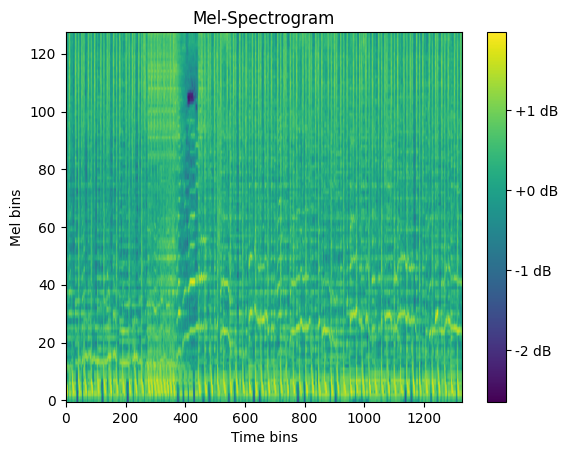

In [188]:
from utils_folder.visualization import plot_spectrogram
# 1, 4, 8
idx = 4
wav, sr = torchaudio.load('/Users/samuelharck/Desktop/masterthesis/data/genres_original/pop/pop.00002.wav')
wav = resampler(wav)
#wav = get_slice(wav, slice_length=slice_length, num_chunks=num_chunks, sample_rate=16000)
wav = wav / torch.max(torch.max(wav, dim=-1, keepdim=True)[0], dim=-2, keepdim=True)[0]
spec = tospec(wav)
mel = spec2mel(torch.abs(spec))
mel = torch.log10(mel+1e-7)[...,5:]
mel = torch.clamp(mel, -4)
plot_spectrogram(mel.squeeze())
Audio(wav, rate=16000)

In [116]:
wav.shape

torch.Size([1, 490383])

In [118]:
wav_cutted = wav[:, 50000:]
Audio(wav_cutted, rate=16000)

In [136]:
wav, sr = torchaudio.load(extended_songlist[idcs[idx]])
wav = wav[:, 160000:]
Audio(wav, rate=22050)

In [193]:
sample_up = torchaudio.transforms.Resample(16000, 22050)
wav, sr = torchaudio.load('/Users/samuelharck/Desktop/masterthesis/data/genres_original/pop/pop.00033.wav')
wav = sample_up(wav)

In [194]:
torchaudio.save('/Users/samuelharck/Desktop/masterthesis/data/genres_original/pop/pop.00033.wav', wav, sample_rate=22050)

wav None None None ===> wav pcm_s16le None


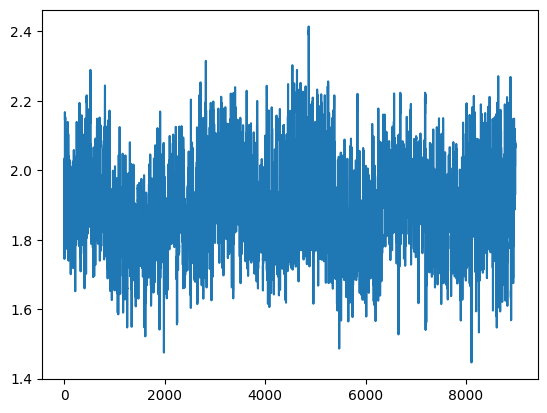

In [61]:
max_vals = torch.max(torch.max(all_specs, dim=-1)[0], dim=-1)[0]
plt.plot(max_vals)

In [59]:
torch.max(torch.max((all_specs == -3), dim=-1)[0], dim=-1)[0].sum()

tensor(0)

mean, std, data_min, data_max, all_specs = calculate_dataset_statistics2('/Users/samuelharck/Desktop/masterthesis/data', slice_length=6, num_chunks=5, case='128_256', audio_normalization='rms')
print(mean, std, data_min, data_max)

In [17]:
mean, std, data_min, data_max, all_specs = calculate_dataset_statistics2('/Users/samuelharck/Desktop/masterthesis/data', slice_length=6, num_chunks=5, case='128_256', audio_normalization='peak')
print(mean, std, data_min, data_max)

torch.Size([4995, 1, 128, 256])
tensor(1.1095) tensor(15.6003) tensor(-100.) tensor(48.6578)


In [6]:
mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=2048, f_min=0.0, f_max=11025.0, n_mels=128, hop_length=1024)
to_db = torchaudio.transforms.AmplitudeToDB()

mean, std, data_min, data_max, all_specs = calculate_dataset_statistics('../../Data/', mel_converter, to_db, 
                                                                        mel_shape=(128,128), slice_length=6, num_chunks=5, case='square128')
print(mean, std)

tensor(22.9381) tensor(14.7086)


## (128,128)

In [6]:
mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=1024, f_min=0.0, f_max=11025.0, n_mels=128, hop_length=512)
to_db = torchaudio.transforms.AmplitudeToDB()

mean, std, data_min, data_max, all_specs = calculate_dataset_statistics('../../Data/', mel_converter, to_db, 
                                                                        mel_shape=(128,256), slice_length=6, num_chunks=5, case='128_256')
print(mean, std)

tensor(16.5831) tensor(15.0282)


## (64,128)

In [4]:
mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_fft=2048, f_min=0.0, f_max=11025.0, n_mels=64, hop_length=1024)
to_db = torchaudio.transforms.AmplitudeToDB()

mean, std, data_min, data_max, all_specs = calculate_dataset_statistics('../../Data/', mel_converter, to_db, 
                                                                        mel_shape=(64,128), slice_length=6, num_chunks=5, case='64_128')
print(mean, std)

tensor(27.4231) tensor(14.1295)


## Toy Data

In [4]:
### clean data

mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=480, f_min=0.0, f_max=8000, n_mels=64)
to_db = torchaudio.transforms.AmplitudeToDB()

mean, std, data_min, data_max, all_specs = calculate_dataset_statistics2('../../toydata/3concepts', case='toy', audio_normalization='peak')
print(mean, std)

torch.Size([2800, 1, 64, 64])
tensor(4.0529e-06) tensor(1.0000)


In [6]:
### noisy data

mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=480, f_min=0.0, f_max=8000, n_mels=64)
to_db = torchaudio.transforms.AmplitudeToDB()

mean, std, data_min, data_max, all_specs = calculate_dataset_statistics('../../toydatasaw/lownoise', mel_converter, to_db, is_toy=True, mel_shape=(64,64))
print(mean, std)

torch.Size([10000, 64, 64])
tensor(12.4056) tensor(12.2668)


### Folds for toy data

In [ ]:
# load all songtitles
"""path = '../../toydatasaw/lownoise/'
class_list = {"class1" : [], "class2" : []}
class_list = get_songs(path, class_list)
make_folds(os.path.join(path, 'splits'), 5, class_list)"""

## Inspection of data preprocessing pipeline

In [2]:
import torchaudio
import sys
sys.path.append('../src/')
from utils import rms_normalizer, get_slice, load_sample

In [4]:
path_to_sample = '../../data/genres_original/hiphop/hiphop.00033.wav'
wav, sr = torchaudio.load(path_to_sample)

In [8]:
mel, bla = load_sample(path_to_sample, to_mel=True, normalize=True)
mel.size()

torch.Size([1, 110250])


torch.Size([1, 128, 216])